Model trained with MSE: 595.60


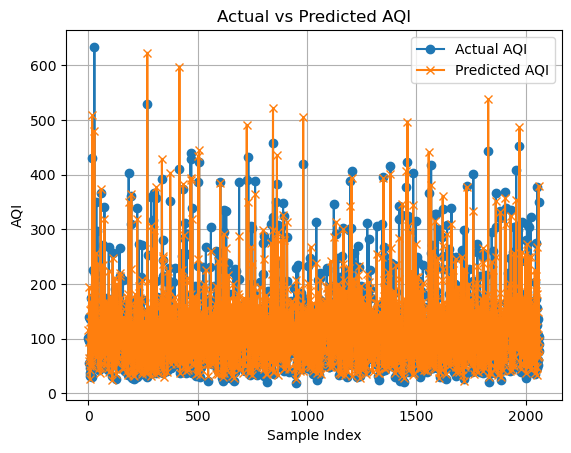

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import tkinter as tk
from tkinter import messagebox
import matplotlib.pyplot as plt

# Step 1: Load and Prepare the Data
def load_data():
    data = pd.read_csv('datasetaqi.csv')  # Replace with your dataset path
    features = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
    target = 'AQI'
    data = data.dropna()
    X = data[features]
    y = data[target]
    return X, y, features

# Step 2: Train the Regression Model
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Model trained with MSE: {mse:.2f}")
    return model, X_test, y_test, y_pred

# Step 3: AQI Category Mapping
def get_aqi_category(aqi_value):
    if aqi_value <= 50:
        return "Good"
    elif aqi_value <= 100:
        return "Moderate"
    elif aqi_value <= 150:
        return "Unhealthy for Sensitive Groups"
    elif aqi_value <= 200:
        return "Unhealthy"
    elif aqi_value <= 300:
        return "Very Unhealthy"
    else:
        return "Hazardous"

# Step 4: Create the Frontend
def create_frontend(model, X_test, y_test, y_pred, features):
    def validate_input(P):
        if P == "" or P.isdigit():
            return True
        try:
            float(P)
            return True
        except ValueError:
            return False

    def move_next(event, current_index):
        if event.keysym in ("Return", "Down"):
            if current_index < len(entries) - 1:
                entries[current_index + 1].focus_set()
            else:
                predict_aqi()
        elif event.keysym == "Up" and current_index > 0:
            entries[current_index - 1].focus_set()

    def predict_aqi():
        try:
            # Convert inputs into DataFrame with proper feature names
            inputs = [float(entry.get()) for entry in entries]
            inputs_df = pd.DataFrame([inputs], columns=features)
            prediction = model.predict(inputs_df)[0]

            category = get_aqi_category(prediction)
            messagebox.showinfo("Prediction", f"Predicted AQI: {prediction:.2f}\nCategory: {category}")
        except ValueError:
            messagebox.showerror("Error", "Please enter valid numeric values.")

    # Create one figure globally (so it updates instead of duplicating)
    fig, ax = plt.subplots()

    def plot_results():
        ax.clear()
        ax.plot(range(len(y_test)), y_test, label='Actual AQI', marker='o')
        ax.plot(range(len(y_pred)), y_pred, label='Predicted AQI', marker='x')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('AQI')
        ax.set_title('Actual vs Predicted AQI')
        ax.legend()
        ax.grid(True)
        fig.canvas.draw()
        plt.show(block=False)

    # Initialize the main window
    window = tk.Tk()
    window.title("Air Quality Index Prediction")
    window.geometry("500x400")

    # Input labels and entry fields
    entries = []
    vcmd = (window.register(validate_input), "%P")

    for i, label in enumerate(features):
        tk.Label(window, text=label).grid(row=i, column=0, padx=10, pady=5)
        entry = tk.Entry(window, validate="key", validatecommand=vcmd)
        entry.grid(row=i, column=1, padx=10, pady=5)
        entries.append(entry)

        # Bind keys for navigation
        entry.bind("<Return>", lambda e, idx=i: move_next(e, idx))
        entry.bind("<Down>", lambda e, idx=i: move_next(e, idx))
        entry.bind("<Up>", lambda e, idx=i: move_next(e, idx))

    # Predict button
    tk.Button(window, text="Predict AQI", command=predict_aqi).grid(row=len(features), column=0, pady=10)

    # Plot Results button
    tk.Button(window, text="Plot Results", command=plot_results).grid(row=len(features), column=1, pady=10)

    # Run the application
    window.mainloop()

if __name__ == "__main__":
    X, y, features = load_data()
    model, X_test, y_test, y_pred = train_model(X, y)
    create_frontend(model, X_test, y_test, y_pred, features)
